# SQLAlchemy Homework Results

## Importing Libraries and Creating Session

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
inspector = inspect(engine)

In [6]:
columns = inspector.get_columns('Measurement')
for x in columns:
    print(x['name'],x['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
columns = inspector.get_columns('Station')
for x in columns:
    print(x['name'],x['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
session = Session(engine)

## Precipitation Analysis

In [9]:
# Issues with datetime format (running through session.query in current dt format)
# start_date = dt.date(2017, 08, 23)
# query_dates = []
# for x in range(0, 366):
#     query_dates.append(start_date - dt.timedelta(days=x))
# session.query(Measurement.date, Measurement.prcp).\
#     filter(Measurement.date == query_dates).\
#     order_by(Measurement.date).all()

In [10]:
query =session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    order_by(Measurement.date).all()

In [11]:
df = pd.DataFrame(query, columns=['date', 'precipitation'])
rain_df = df.fillna(0.0)
rain_df.set_index('date', inplace=False)
rain_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.00
4,2016-08-23,0.02


In [12]:
grouped_df = rain_df.groupby('date').agg({'precipitation': 'mean'}).reset_index('date')
grouped_df.head()

,date,precipitation
0,2016-08-23,0.387143
1,2016-08-24,1.332857
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.053333


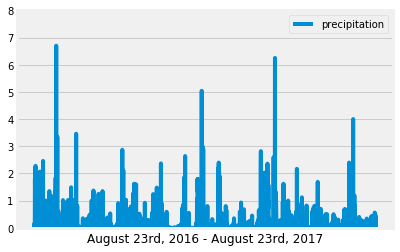

In [13]:
rain_df.plot()
plt.ylim(0,8)
plt.xticks([])
plt.xlabel('August 23rd, 2016 - August 23rd, 2017')
plt.grid(True)
plt.show()

In [14]:
rain_df.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


## Station Analysis

In [15]:
session.query(Measurement.station).\
    distinct(Measurement.station.name).\
    count()

9

In [16]:
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
temp_query = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    order_by(Measurement.date).all()

In [18]:
temp_df = pd.DataFrame(temp_query, columns=['temperature'])
temp_df = temp_df.fillna(0)
temp_df.head()

,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


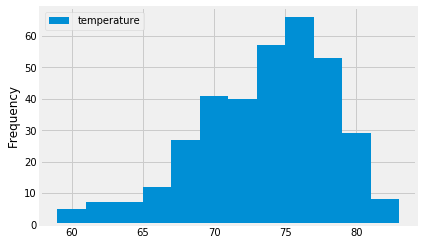

In [19]:
temp_df.plot.hist(bins=12)
plt.show()

## Temperature Analysis

In [29]:
def trip(start_date, end_date):
    query = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    for x in query:
        result = list(x)
    
    return(result)

print(trip('2015-07-05', '2015-07-19'))

[71.0, 77.6734693877551, 83.0]


[]

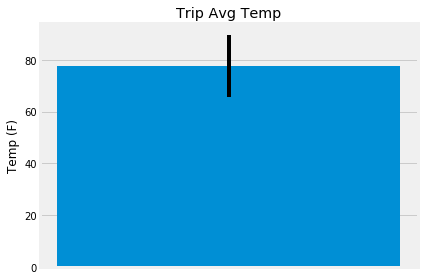

In [57]:
y_pos = np.arange(1)
error_bar = trip('2015-07-05', '2015-07-19')[2] - trip('2015-07-05', '2015-07-19')[0]
plt.bar(0, trip('2015-07-05', '2015-07-19')[1], width=.1, yerr=error_bar)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.tight_layout()
plt.plot()